In [54]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, BasisType
from qiskit.chemistry.core import Hamiltonian, QubitMappingType
from qiskit.chemistry.transformations import FermionicTransformation
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
import numpy as np
from math import pi
import matplotlib.pyplot as plt

In [5]:
# inter-atomic distance 
start = 0.5
step_size = 0.025
number_steps = 20
# Total distance increased = 0.5

# Number of distances thus created
distance = np.empty(number_steps + 1)    # 20 plus the start point 0.5
# np.empty(shape of array, data_type, ...)

distance[0] = start
for i in range(number_steps + 1):
    distance[i] = start + (i * step_size)
print(distance)

# or simply use this.
# distance = np.arange(0.5, 4.0, 0.1) 

[0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]


In [68]:
# Defining the molecule. 
# Each atom is seperated by semi colon (;) and, 
# Each atom is followed by a distance.
molecule = "H .0 .0 .0; H .0 .0 "
# molecule = "H .0 .0 -{0}; H .0 .0 {0}".format([d/2 for d in distance])

energy = []
hartree_fock_energy = []

for d in distance:
    driver = PySCFDriver(atom = molecule + str(d), unit = UnitsType.ANGSTROM, charge = 0, spin = 0, basis = 'sto3g')
    # Check what is basis type! 'sto3g' = BasisType.sto3g

    # qmolecule = driver.run()
    # print(qmolecule)

    operator = FermionicTransformation(qubit_mapping = QubitMappingType.PARITY)
    # or use Hamiltonian(qubit_mapping) but Hamiltonian is depriciated
    
    qubit_operator, auxiliary_operator = operator.transform(driver)
    # print(qubit_operator, auxiliary_operator)
    # SummedOp([-1.0692434904119303 * II, 0.26752864994208625 * IZ, 0.2675286499420862 * ZI, -0.00901493005816631 * ZZ, 0.19679058348547032 * XX])
    
    result = NumPyMinimumEigensolver(qubit_operator).run()
    # print(result)
    
    result = operator.interpret(result)
    # print(result)
    
    energy.append(float(result.total_energies))
    hartree_fock_energy.append(result.hartree_fock_energy)
    
print('energy: ', energy)
print('hf: ', hartree_fock_energy)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.113514216311
  - computed part:      -2.113514216311
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 1.05835442184
> Total ground state energy (Hartree): -1.055159794471
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.94486306]
 
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.083870247418
  - computed part:      -2.083870247418
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 1.007956592229
> Total ground state energy (Hartree): -1.075913655189
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.99210622]
 
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.054770290236
  - computed part:      -2.054770290236
  - frozen energy part: 0.0
  - particle hole par

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.630327541153
  - computed part:      -1.630327541153
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.52917721092
> Total ground state energy (Hartree): -1.101150330233
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.88972612]
 
energy:  [-1.0551597944706248, -1.0759136551892523, -1.0926299067451017, -1.1059180532539958, -1.1162860068695355, -1.1241609196298905, -1.1299047843229126, -1.1338262151438594, -1.1361894540659212, -1.1372213770723034, -1.1371170673457311, -1.1360443632279171, -1.1341476666770975, -1.131551205907274, -1.1283618784581066, -1.124671753566133, -1.1205602812999853, -1.1160962367918685, -1.111339417736151, -1.1063421092874393, -1.1011503302326169]
hf:  [-1.042996274540095, -1.0630621429206066, -1.0790507361774568, -1.0915704967771855, -1.101128242267701, -1.1081499901921303, -1.112996545

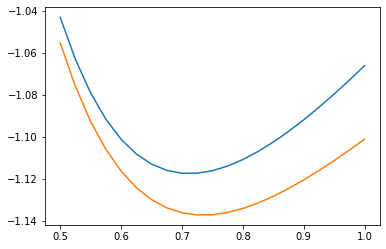

In [69]:
x_axis = distance
y_axis = hartree_fock_energy
y_axis_2 = energy

plt.plot(x_axis, y_axis)
plt.plot(x_axis, y_axis_2)

**Refer1:** https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Structure-of-Common-Variational-Forms

**Refer2:** https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/chemistry/h2_vqe_initial_point.ipynb